In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

In [2]:
train_path = "./03_iris_training/"
filenames = os.listdir(train_path)

labels = []
kinds = []

for i in range(0, len(filenames)):
    label = filenames[i][:3]
    kind = filenames[i][3]
    labels.append(label)
    kinds.append(kind)

df = pd.DataFrame({'filename':filenames, 'label':labels, 'kind':kinds})
df

,filename,label,kind
0,001L_1.png,001,L
1,001R_1.png,001,R
2,002L_1.png,002,L
3,002R_1.png,002,R
4,003L_1.png,003,L
...,...,...,...
123,062R_1.png,062,R
124,063L_1.png,063,L
125,063R_1.png,063,R
126,064L_1.png,064,L


(576, 768, 3)


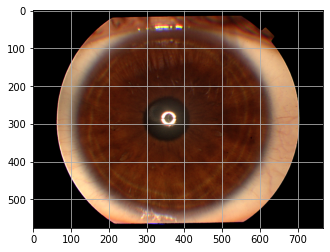

(576, 640, 3)


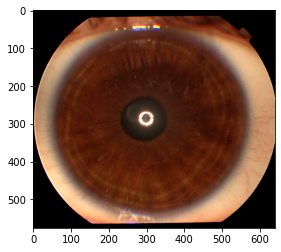

(288, 320, 3)


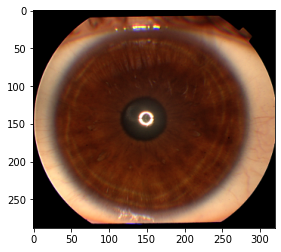

In [3]:
img = cv2.imread(train_path + df.iloc[0,0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
plt.grid(True)
plt.imshow(img)
plt.show()

crop_img=img[:,60:700]
print(crop_img.shape)
plt.grid(False)
plt.imshow(crop_img)
plt.show()

resize_img = cv2.resize(crop_img, (320, 288))
print(resize_img.shape)
plt.grid(False)
plt.imshow(resize_img)
plt.show()

In [4]:
def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, 60:700]
    img = cv2.resize(img, (320, 288))
    return img

In [5]:
aug_path = "./03_iris_aug/"

In [6]:
aug_datagen = ImageDataGenerator(
    zoom_range=0.075,
    width_shift_range=0.075,
    height_shift_range=0.075,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
)

for i in range(df.shape[0]):
    img = load_img(train_path + df['filename'][i])
    cv2.imwrite(aug_path + df['filename'][i], cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    j = 1
    for batch in aug_datagen.flow(x=img, save_to_dir=aug_path, save_format="png",
                                  save_prefix=df['label'][i]+df['kind'][i],
                                  batch_size=1):
        j = j+1
        if j>5:
            break

In [7]:
filenames = os.listdir(aug_path)

labels = []
kinds = []

for i in range(0, len(filenames)):
    label = filenames[i][:3]
    kind = filenames[i][3]
    labels.append(label)
    kinds.append(kind)

df = pd.DataFrame({'filename':filenames, 'label':labels, 'kind':kinds})
df

,filename,label,kind
0,001L_0_1509.png,001,L
1,001L_0_1966.png,001,L
2,001L_0_3426.png,001,L
3,001L_0_4670.png,001,L
4,001L_0_4852.png,001,L
...,...,...,...
763,064R_0_2759.png,064,R
764,064R_0_2786.png,064,R
765,064R_0_8930.png,064,R
766,064R_0_9000.png,064,R


In [8]:
def load_scale_reshape(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    return img

In [9]:
X = load_scale_reshape(aug_path + df['filename'][0])

for i in range(1, df.shape[0]):
    img = load_scale_reshape(aug_path + df['filename'][i])
    X = np.concatenate((X, img), axis=0)

print(X.shape)

Y = df['label']
Y = pd.get_dummies(Y)
print(Y.shape)

(768, 288, 320, 3)
(768, 64)


In [10]:
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_CHANNELS = X.shape[-1]
OUTPUT_SIZE = len(df['label'].unique())

In [11]:
def create_model():
    input = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input)
    
    for layer in base_model.layers[:44]:
        layer.trainable = False
    
    X = base_model.output
    X = BatchNormalization()(X)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.3)(X)
    
    X = Dense(512, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    Y = Dense(OUTPUT_SIZE, activation='softmax')(X)
    
    model = tf.keras.Model(inputs = input, outputs = Y)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000075),
                 metrics=['accuracy', Precision(), Recall()])
    model.summary()
    
    return model

In [12]:
def acc_graph(history):
    from pylab import rcParams
    from matplotlib import pyplot as plt
    rcParams['figure.figsize'] = 10, 4
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 294, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 144, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 146, 162, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

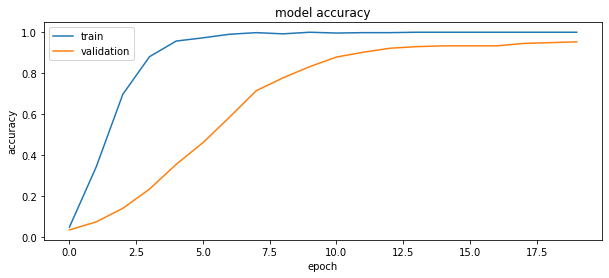

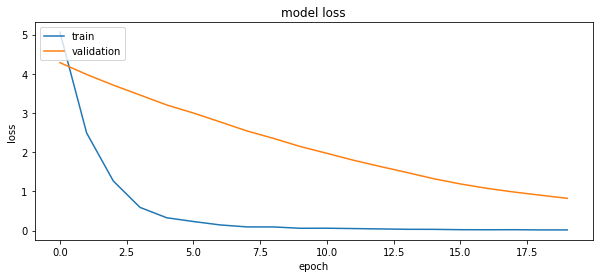

8/8 [==============================] - 40s 5s/step - loss: 0.8241 - accuracy: 0.9531 - precision: 1.0000 - recall: 0.5664
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 288, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 294, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 144, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 146, 162, 64) 0           conv

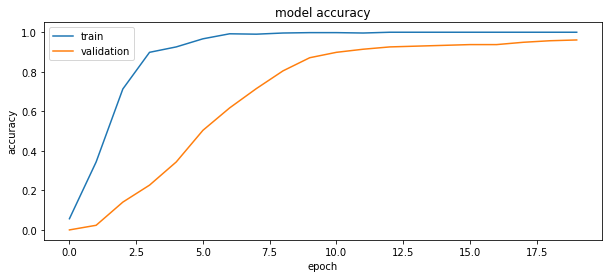

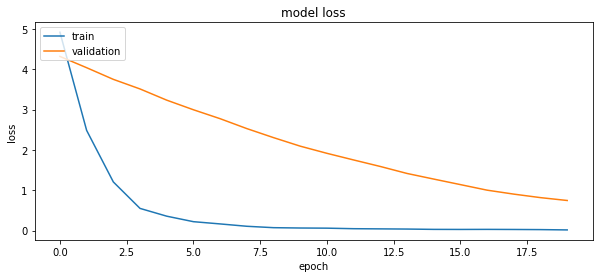

8/8 [==============================] - 39s 5s/step - loss: 0.7454 - accuracy: 0.9609 - precision_1: 1.0000 - recall_1: 0.6094
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 288, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 294, 326, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 144, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 146, 162, 64) 0           

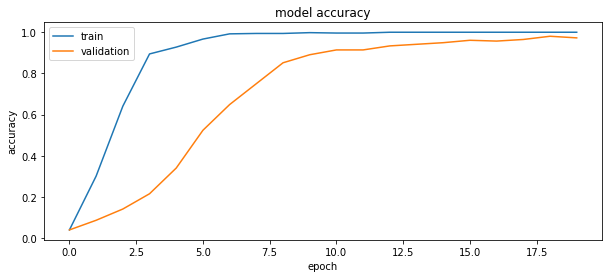

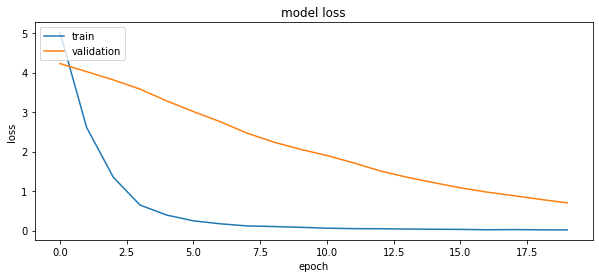

8/8 [==============================] - 39s 5s/step - loss: 0.7007 - accuracy: 0.9727 - precision_2: 1.0000 - recall_2: 0.6250


In [13]:
batch_size = 32
epoch = 20
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
scores =[]

skf = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, val_index in skf.split(X, df['label']):
    train_X, val_X = X[train_index], X[val_index]
    train_Y, val_Y = Y.iloc[train_index], Y.iloc[val_index]
    
    model = create_model()
    
    history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epoch,
                   validation_data = (val_X, val_Y), callbacks=[es])

    acc_graph(history)

    evaluation = model.evaluate(val_X, val_Y, batch_size = batch_size)
    scores.append(evaluation)

In [19]:
scores_df = pd.DataFrame(scores, columns=['loss','accuracy','precision', 'recall'])

In [20]:
scores_df['f1-score'] = (2*scores_df['precision']*scores_df['recall'])/(scores_df['precision']+scores_df['recall'])

In [21]:
scores_df

,loss,accuracy,precision,recall,f1-score
0,0.824139,0.953125,1.0,0.566406,0.723192
1,0.745449,0.960938,1.0,0.609375,0.757282
2,0.700685,0.972656,1.0,0.625000,0.769231


In [22]:
scores_df.mean()

loss         0.756758
accuracy     0.962240
precision    1.000000
recall       0.600260
f1-score     0.749901
dtype: float64

In [25]:
def test_load(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, 60:700]
    img = cv2.resize(img, (320, 288))
    img = img/255.
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[-1])
    return img

In [26]:
test_path = "./03_iris_test/"
filenames = os.listdir(test_path)

nums = []
for i in range(0, len(filenames)):
    num = filenames[i].split('.')[0]
    nums.append(num)

test_df = pd.DataFrame({'num':nums, 'filename':filenames}) 
test_df = test_df.astype({'num':'uint16'})

test_X = test_load(test_path+test_df['filename'][0])

for i in range(1,test_df.shape[0]):
    img = test_load(test_path+test_df['filename'][i])
    test_X = np.concatenate((test_X, img), axis=0)

print(test_X.shape)

(256, 288, 320, 3)


In [27]:
pred = pd.DataFrame(model.predict(test_X))
pred = pred.round(decimals=2)
pred

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.01,0.01,0.00,0.01,0.02,0.00,0.03,0.01,0.00,0.00,...,0.01,0.01,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.05
2,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.01,0.01,0.06,0.01,0.02,0.01,0.01,0.01,...,0.01,0.01,0.03,0.00,0.01,0.01,0.00,0.00,0.00,0.02
4,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.00,0.57
252,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03
253,0.01,0.01,0.01,0.02,0.01,0.03,0.04,0.01,0.01,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.01,0.00,0.00,0.01
254,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,...,0.01,0.02,0.01,0.02,0.01,0.00,0.01,0.01,0.02,0.00


In [28]:
answer = pred.idxmax(axis=1)+1

In [29]:
test_df = pd.concat([test_df, answer, pred], axis=1)
test_df = test_df.sort_values(by=['num'])

In [30]:
col = ['Image', 'Filename', 'Answer']
for i in range(OUTPUT_SIZE):
    col.append('pred_'+str(i+1))
test_df.columns = col

In [31]:
test_df

,Image,Filename,Answer,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,...,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64
0,1,1.png,46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
111,2,2.png,59,0.01,0.00,0.00,0.01,0.01,0.00,0.00,...,0.00,0.00,0.01,0.01,0.68,0.00,0.01,0.00,0.00,0.01
179,3,3.png,26,0.01,0.01,0.00,0.00,0.02,0.01,0.01,...,0.02,0.01,0.02,0.04,0.01,0.02,0.01,0.01,0.00,0.01
190,4,4.png,46,0.00,0.00,0.01,0.01,0.01,0.00,0.00,...,0.01,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.02,0.00
201,5,5.png,51,0.01,0.00,0.00,0.01,0.01,0.00,0.01,...,0.00,0.01,0.01,0.02,0.03,0.00,0.05,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,252,252.png,21,0.01,0.01,0.00,0.00,0.01,0.01,0.00,...,0.01,0.00,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01
171,253,253.png,14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
172,254,254.png,26,0.00,0.00,0.00,0.01,0.01,0.00,0.01,...,0.01,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.01
173,255,255.png,45,0.00,0.01,0.01,0.00,0.02,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00


In [32]:
ans_df = test_df[['Image', 'Answer']]
ans_df

,Image,Answer
0,1,46
111,2,59
179,3,26
190,4,46
201,5,51
...,...,...
170,252,21
171,253,14
172,254,26
173,255,45


In [34]:
ans_df.to_csv('./answer.csv', header=True, index=False)